<a href="https://colab.research.google.com/github/Abhijit-2592/visualizing_cnns/blob/master/activation_maximization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In this and the saliency_map.ipynb notebooks we will try to understand the visualization technique presented in the following paper:


[Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf).

Specifically we will visualize the idea given in Section 2: Class Model Visualisation

The idea is: We are trying to find an input image such that the probability of the network predicting a specific class is maximum. This is again done by **gradient ascent**.

## NOTE:

In the paper under section 3, the authors approximate the linear scoring function by using the 1st order term from the Tailor expansion of the softmax function (See equations 2 and 3). Instead of taking the 1st order term from the Tailor expansion we can do another trick to approximate a Linear scoring function: Just Swap the Softmax activation to a Linear/Identity activation in the output.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
np.random.seed(500)

In [0]:
%matplotlib inline

In [5]:
print(tf.__version__)
print(np.__version__)

2.1.0
1.17.5


In [0]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

In [7]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# trick to get optimal visualizations: swap softmax with identity/linear
model.get_layer("predictions").activation = None

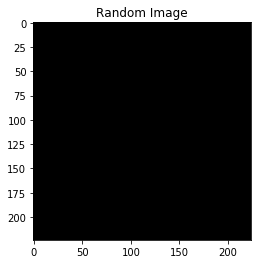

In [9]:
random_image = np.zeros((224, 224, 3)).astype(np.float32)
plt.title("Random Image")
plt.imshow(random_image)
plt.show()
random_image = np.expand_dims(random_image, axis=0)  # reshape it to (1,224,224,3)

In [0]:
def get_gradients(model, image, class_index):
    image_tensor = tf.convert_to_tensor(image, dtype="float32")
    with tf.GradientTape() as tape:
      # The visualization is very sensitive to the regularization parameter!
        regularizer_l2 = tf.keras.regularizers.l2(l=0.01)
        tape.watch(image_tensor)
        output = model(image_tensor)
        loss = tf.reduce_mean(output[:, class_index] - regularizer_l2(image_tensor))
    grads = tape.gradient(loss, image_tensor)
    return grads

# Let's visualize the class Ouzel. It's imagenet index = 20

Ouzel is a bird: Just google it :P

In [11]:
step_size = 1
epochs = 1000
class_index = 20  # ouzel
progbar = tf.keras.utils.Progbar(epochs)
for i in range(epochs):
    grads = get_gradients(model, random_image, class_index=class_index)
    random_image += grads * step_size   # + is gradient ascent
    progbar.update(i+1)

1000/1000 [==============================] - 64s 64ms/step


In [0]:
def deprocess_image(x):
    """Utility function to convert a tensor into a valid image
    """
    x = np.squeeze(x.numpy(), axis=0)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
activation_maximization = deprocess_image(random_image)

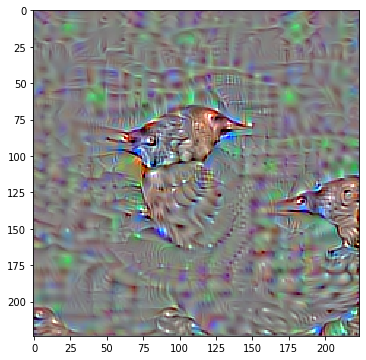

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(activation_maximization)
plt.show()

Ah well look at that! The network not only learnt what **Ouzel** Looks like but has also learnt different orientations and sizes of it. This shows that our classification network is scale and translational invarient. Thanks to Max pooling operations maybe? ;P